In [24]:
import os
import pickle
import glob
import shap
import random
import numpy as np
import pandas as pd
from pathlib import Path

# Shap Analysis

In [25]:
experiment_path = "../OUTPUT/AMD_Final"
outcome_label = 'conversion'
instance_label = None
algorithms = [] # use empty list if user wishes re-evaluate all modeling algorithms that were run in pipeline.

In [26]:
# Get dataset paths for all completed dataset analyses in experiment folder
datasets = os.listdir(experiment_path)

# Name of experiment folder
experiment_name = experiment_path.split('/')[-1] 

datasets = os.listdir(experiment_path)
remove_list = ['.DS_Store', 'metadata.pickle', 'metadata.csv', 'algInfo.pickle',
                'DatasetComparisons', 'jobs', 'jobsCompleted', 'logs',
                'KeyFileCopy', 'dask_logs',
                experiment_name + '_ML_Pipeline_Report.pdf']
for text in remove_list:
    if text in datasets:
        datasets.remove(text)

datasets = sorted(datasets) # ensures consistent ordering of datasets
print("Analyzed Datasets: " + str(datasets))

Analyzed Datasets: ['AMD_Data_Final']


In [27]:
# Unpickle metadata from previous phase
file = open(experiment_path + '/' + "metadata.pickle", 'rb')
metadata = pickle.load(file)
file.close()
# Load variables specified earlier in the pipeline from metadata
outcome_label = metadata['Class Label']
instance_label = metadata['Instance Label']
cv_partitions = int(metadata['CV Partitions'])

# Unpickle algorithm information from previous phase
file = open(experiment_path + '/' + "algInfo.pickle", 'rb')
algInfo = pickle.load(file)
file.close()
algorithms = []
abbrevs = {}
for key in algInfo:
    if algInfo[key][0]: # If that algorithm was used
        algorithms.append(key)
        abbrevs[key] = (algInfo[key][1])

print("Algorithms Ran: " + str(algorithms))

Algorithms Ran: ['Decision Tree', 'Genetic Programming', 'ExSTraCS', 'XCS', 'eLCS', 'K-Nearest Neighbors', 'Support Vector Machine', 'Category Gradient Boosting', 'Gradient Boosting', 'Light Gradient Boosting', 'Extreme Gradient Boosting', 'Elastic Net', 'Random Forest', 'Logistic Regression', 'Naive Bayes', 'Artificial Neural Network']


In [28]:
algorithms = ['Light Gradient Boosting']

In [29]:
def run_plots(train_file_path, test_file_path, outcome_label="Class", instance_label=None, random_state=42):
    random.seed(random_state)
    np.random.seed(random_state)
    # Load training and testing datasets separating features from outcome for scikit-learn-based modeling
    train = pd.read_csv(train_file_path)
    test = pd.read_csv(test_file_path)
    if instance_label is not None:
        train = train.drop(instance_label, axis=1)
        test = test.drop(instance_label, axis=1)
    x_train = train.drop(outcome_label, axis=1).values
    y_train = train[outcome_label].values
    x_test = test.drop(outcome_label, axis=1).values
    y_test = test[outcome_label].values
    if 10000 < x_train.shape[0]:
        sss = StratifiedShuffleSplit(n_splits=1, train_size=10000, random_state=random_state)
        for train_index, _ in sss.split(x_train, y_train):
            x_train = x_train[train_index]
            y_train = y_train[train_index]
        logging.warning('For ' + algorithm + ', training sample reduced to ' + str(x_train.shape[0]) + ' instances')
    
    model_info = full_path + '/models/pickledModels/' + abbrevs[algorithm] + '_' + str(cv_count) + '.pickle'
    # Corresponding pickle file name with scalingInfo
    infile = open(model_info, 'rb')
    model = pickle.load(infile)
    infile.close()

    #explaining model
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_test)
    #for each iteration we save the test_set index and the shap_values
    return shap_values, x_test

Trying to unpickle estimator LabelEncoder from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
Trying to unpickle estimator LabelEncoder from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
Trying to unpickle estimator LabelEncoder from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_per

['AF', 'Age', 'BMI', 'Biologicals', 'CAD', 'CVA', 'Cancer', 'Cataract', 'DM', 'DME', 'Diabetic retinopathy', 'Endophthalmitis', 'Glaucoma', 'HLD', 'Insulin', 'LeftVA', 'Race_0', 'Race_1', 'RightVA', 'Sex', 'Smoking_0.0', 'Smoking_1.0', 'Smoking_2.0']


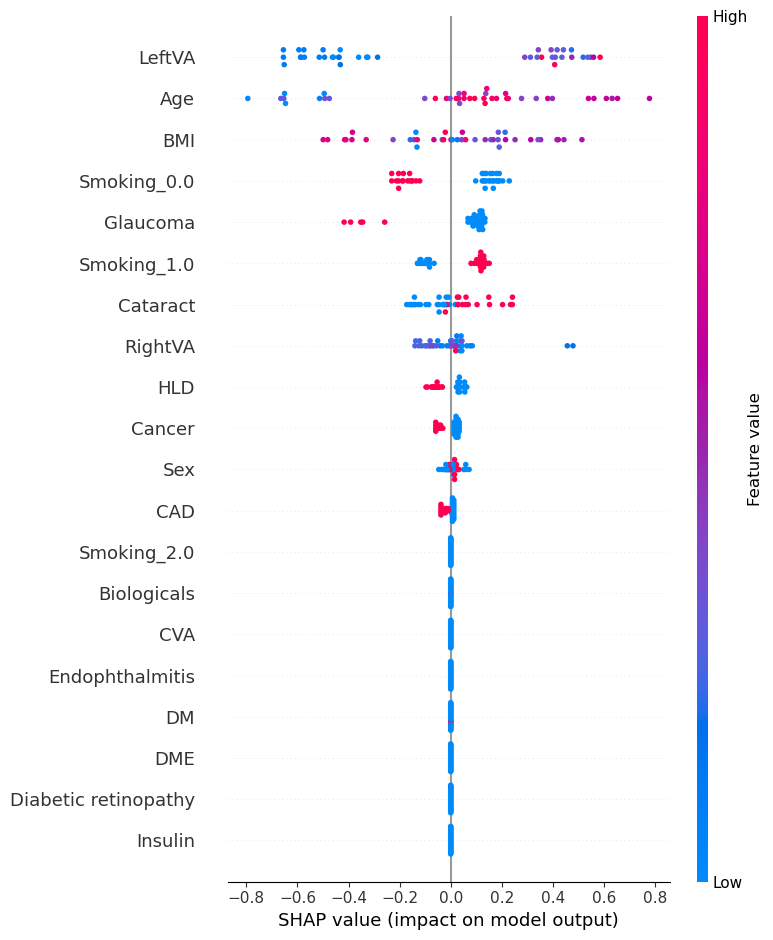

In [33]:
list_shap_values = list()
list_test_sets = list()
for dataset_directory_path in datasets:
    full_path = experiment_path + "/" + dataset_directory_path
    cv_dataset_paths = list(glob.glob(full_path + "/CVDatasets/*_CV_*Train.csv"))
    cv_dataset_paths = [str(Path(cv_dataset_path)) for cv_dataset_path in cv_dataset_paths]
    cv_partitions = len(cv_dataset_paths)
    data_name = full_path.split('/')[-1]
    for cv_count in range(cv_partitions):
        for algorithm in algorithms:
            abbrev = abbrevs[algorithm]
            train_file_path = full_path + '/CVDatasets/' + data_name \
                               + '_CV_' + str(cv_count) + '_Train.csv'
            test_file_path = full_path + '/CVDatasets/' + data_name \
                              + '_CV_' + str(cv_count) + '_Test.csv'
            shap_values, x_test = run_plots(train_file_path, test_file_path, 
                                                outcome_label, instance_label, random_state=42)
    list_shap_values.append(shap_values)
    list_test_sets.append(x_test)
    
columns = list(pd.read_csv(train_file_path).columns)
columns.remove(outcome_label)
if instance_label is not None:
    columns.remove(instance_label)
print(columns)
shap_values = np.array(list_shap_values[0])
for i in range(1,len(list_test_sets)):
    test_set = np.concatenate((test_set,list_test_sets[i]),axis=0)
    shap_values = np.concatenate((shap_values,np.array(list_shap_values[i])),axis=1)
#bringing back variable names    
X_test = pd.DataFrame(test_set, columns=columns)

#creating explanation plot for the whole experiment, the first dimension from shap_values indicate the class we are predicting (0=0, 1=1)
shap.summary_plot(shap_values[1], X_test)